In [1]:
%config InlineBackend.figure_format='retina'
import pygmt
import xarray as xr
import pandas as pd
import numpy as np
import yaml
import os
from collections import OrderedDict

In [2]:
with open("gmt_config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

In [3]:
cbar_len = 11
def re_scale(cbar_len):
    return np.sqrt(cbar_len/15)

In [4]:
def test_fg_subplots(fgdata, savepath):
    region = cfg['moriches_map']['region']
    frame_params = cfg['moriches_map']['basemap_frame']
    grid = '../../bathymetry/moriches.nc'
    grd = pygmt.grdclip(grid=grid, below=[0.0, -50])
    
   # Calculate subplot layout
    n_subplots = len(fgdata)
    if n_subplots == 2:  # Special case for two subplots
        nrows, ncols = 1, 2
        margins = '0.5c'
    else:
        ncols = 2  # Default to 2 columns
        nrows = -(-n_subplots // ncols)  # Ceiling division for rows
        margins = '0.5c' if nrows > 1 else '1c'  # Larger margin for single row

    subsize = '8.25c'  # Uniform subplot size
    fig = pygmt.Figure()
    with pygmt.config(**cfg['region_map']):
        with fig.subplot(
            nrows=nrows,
            ncols=ncols,
            subsize=[subsize],
            frame='lrtb',
            autolabel='(a)+gwhite',
            sharex='b',
            sharey='l',
            region=region,
            margins=margins,
            projection='M8.25c'
        ):
            for i, key in enumerate(fgdata):
                with fig.set_panel(panel=i):
                    pygmt.makecpt(cmap='gray', series=[-50, 50], reverse=True)
                    fig.grdimage(region=region, projection='M?', grid=grd, cmap=True, shading=True)
                    pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False, reverse=True)
                    fig.grdimage(grid=fgdata[key]['data'], cmap=True, nan_transparent=True)
                    pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
                    if fgdata[key]['mesh']:
                        fig.plot(data=fgdata[key]['mesh'], fill='+z', pen="0.1p", close=True, cmap=True)
                    
                    # Add annotations and lines
                    third = 0.07663580247030193
                    west = -72.87995371851132 + third
                    east = -72.65004631110041 - third
                    fig.text(x=west - (third / 2), y=40.724, text='west', font='black')
                    fig.text(x=east - (third / 2), y=40.724, text='central', font='black')
                    fig.text(x=east + (third / 2), y=40.724, text='east', font='black')
                    west_x = np.linspace(west, west, 20)
                    y = np.linspace(region[2], region[3], 20)
                    east_x = np.linspace(east, east, 20)
                    fig.plot(x=west_x, y=y, pen='1p,black,-')
                    fig.plot(x=east_x, y=y, pen='1p,black,-')
        
        # Adjust colorbar positions dynamically
        scaling = re_scale(cbar_len)
        
        if nrows == 1:  # Single row layout
            surge_cbar_position = 'JMR+o1c/0c+w5.5c/0.5c+mc'
            breach_cbar_position = 'JBC+o0c/1.15c+w15c/.5ch+mc'
        else:  # Multi-row layout
            surge_cbar_position = 'JMR+o1c/0c+w11c/0.5c+mc'
            breach_cbar_position = 'JBC+o-0c/1.15c+w15c/.5ch+mc'
        
        with pygmt.config(
            FONT_ANNOT=f"{16/scaling}p",
            FONT_LABEL=f"{16/scaling}p",
            ): 
            pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False,
                          reverse=True)
            fig.colorbar(position=surge_cbar_position,  # "JMR+o1c/0c+w7c/0.5c+n+mc",
                         frame=['xa.3f.10+lSea Surface (m)'],
                         )
        with pygmt.config(FONT_ANNOT_PRIMARY='16p,Times-Roman'): #, FONT_ANNOT_PRIMARY="16p", FONT_LABEL="16p"):
            pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
            fig.colorbar(position=breach_cbar_position,
                      frame=['xa.3f.10+lBreach Depth (m)'])

            fig.colorbar(position=breach_cbar_position, frame=['xa.3f.10+lBreach Depth (m)'])

    fig.savefig(savepath, transparent=False, dpi=300)
    fig.show(verbose='i')


In [5]:
def plot_fg_subplots(fgdata, savepath):
    region = cfg['moriches_map']['region']
    frame_params = cfg['moriches_map']['basemap_frame']
    grid = '../../bathymetry/moriches.nc'
    grd = pygmt.grdclip(grid=grid, below=[0.0, -50])
    
    fig = pygmt.Figure()
    with (pygmt.config(**cfg['region_map'])):
        with fig.subplot(
            nrows=int(round(len(fgdata) / 2)),
            ncols=2,
            subsize=['8.25c'],  frame='lrtb',
            autolabel='(a)+gwhite',
            sharex='b',
            sharey='l',
            region = region,
            margins = '0.5c',
            projection = 'M8.25c'):
            for i, key in enumerate(fgdata):
                with fig.set_panel(panel=i):
                    with (pygmt.config(**cfg['region_map'])):
                        pygmt.makecpt(cmap='gray', series=[-50, 50], reverse=True)
                        fig.grdimage(region=region, projection='M?', grid=grd, cmap=True, shading=True)
                        pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False,
                                      reverse=True)
                        fig.grdimage(grid=fgdata[key]['data'], cmap=True, nan_transparent=True)
                        pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
                        if fgdata[key]['mesh']:
                            fig.plot(data=fgdata[key]['mesh'], fill='+z', pen="0.1p", close=True, cmap=True)
                        third = 0.07663580247030193
                        west = -72.87995371851132 + third
                        east = -72.65004631110041 - third
                        with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                            fig.text(x=west-(third/2), y=40.724, text='west', font='black')
                            fig.text(x=east - (third/2), y=40.724, text='central', font='black')
                            fig.text(x=east+(third/2), y=40.724, text='east', font='black')
                        west_x = np.linspace(west, west, 20)
                        y = np.linspace(region[2], region[3], 20)
                        east_x = np.linspace(east, east, 20)
    
                        fig.plot(x=west_x, y=y, pen='1p,black,-')
                        fig.plot(x=east_x, y=y, pen='1p,black,-')
   
        if int(len(fgdata) / 2) == 2:
            print(2)
            surge_cbar_position = 'JMR+o1c/0c+w11c/0.5c+mc' #'jML+w11c/.5c+mc'
            breach_cbar_position = 'JBC+o-0c/1.15c+w15c/.5ch+mc'
            cbar_len = 15
            scaling = re_scale(cbar_len)
        else:
            cbar_len = 5.35
            scaling = re_scale(cbar_len)
            surge_cbar_position = f'JMR+w{cbar_len}c/.5c+o0.95c/0c+mc'
            breach_cbar_position = 'JBC+o0c/1.15c+w15c/.5c+mc'
        with pygmt.config(
            FONT_ANNOT=f"{16/scaling}p",
            FONT_LABEL=f"{16/scaling}p",
            MAP_TICK_LENGTH_PRIMARY=f"{5/scaling}p",
            MAP_TICK_LENGTH_SECONDARY=f"{2.5/scaling}p",
            MAP_ANNOT_OFFSET=f"{5/scaling}p"):   
            pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False,
                          reverse=True)
            fig.colorbar(position=surge_cbar_position,  # "JMR+o1c/0c+w7c/0.5c+n+mc",
                         frame=['xa.3f.10+lSea Surface (m)'],
                         )
        with pygmt.config(FONT_ANNOT_PRIMARY='16p,Times-Roman'): #, FONT_ANNOT_PRIMARY="16p", FONT_LABEL="16p"):
            pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
            fig.colorbar(position=breach_cbar_position,
                      frame=['xa.3f.10+lBreach Depth (m)'])

    fig.savefig(savepath, transparent=False, dpi=300)
    fig.show(verbose='i')


In [6]:
def plot_inset_subplots(fgdata, savepath):
    r1 =  [-72.879, (-72.84700 +  -72.839850 )/2, 40.73363, 40.753449]
    annot_locs = {'Forge River': [-72.83288, 40.80620986],
                  'Seatuck Cove': [-72.7260 - .030, 40.8094],
                  }
    import yaml
    with open("gmt_config.yml", "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)
    fig = pygmt.Figure()
    nrows=1

    with (pygmt.config(**cfg['region_map'])):
        region = cfg['moriches_map']['region']
        frame_params = cfg['moriches_map']['basemap_frame']
        grid = '../../bathymetry/moriches.nc'
        grd = pygmt.grdclip(grid=grid, below=[0.0, -50])
      

        with (pygmt.config(**cfg['region_map'])):
            with fig.subplot(
                nrows=1,
                ncols=2,
                subsize=['8.25c'],  frame='lrtb',
                autolabel='(a)+gwhite',
                sharex='b',
                sharey='l',
                region = region,
                margins = '0.5c',
                projection = 'M8.25c'):
                for i, key in enumerate(fgdata):
                    with fig.set_panel(panel=i):

                        pygmt.makecpt(cmap='gray', series=[-50, 50], reverse=True)
                        fig.grdimage(region=region, projection='M?', grid=grd, cmap=True, shading=True)
                        pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False,
                                      reverse=True)
                        fig.grdimage(grid=fgdata[key]['data'], cmap=True, nan_transparent=True)
                        # for key, data in annot_locs.items():
                        #     fig.text(x=data[0], y=data[1], text=key, font='12p,Helvetic-Bold,black', fill='white')
                        pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
                        if fgdata[key]['mesh']:
                            fig.plot(data=fgdata[key]['mesh'], fill='+z', pen="0.1p", close=True, cmap=True)
                        third = 0.07663580247030193
                        west = -72.87995371851132 + third
                        east = -72.65004631110041 - third
                        west_x = np.linspace(west, west, 20)
                        y = np.linspace(region[2], region[3], 20)
                        east_x = np.linspace(east, east, 20)
                        with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                            fig.text(x=west-(third/2), y=40.724, text='west', font='black')
                            fig.text(x=east - (third/2), y=40.724, text='central', font='black')
                            fig.text(x=east+(third/2), y=40.724, text='east', font='black')
                        fig.plot(x=west_x, y=y, pen='1p,black,-')
                        fig.plot(x=east_x, y=y, pen='1p,black,-')
                        rectangle = [[r1[0], r1[2], r1[1], r1[3]]]
                        fig.plot(data=rectangle, style='r+s', pen='2p,black')
                        with pygmt.config(MAP_FRAME_TYPE='plain'):
                            with fig.inset(position='jTL+w2.7c/2c', box='+pblack'):
                                inset_region = r1
                                fig.basemap(region=inset_region,
                                            frame=True,
                                            projection='M?',
                                            )
                                pygmt.makecpt(cmap='gray', series=[-50, 50], reverse=True)
                                fig.grdimage(grid=grd, cmap=True, shading=True)
                                pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False,
                                              reverse=True)
                                fig.grdimage(grid=fgdata[key]['data'], cmap=True, nan_transparent=True)
                                # for key, data in annot_locs.items():
                                #     fig.text(x=data[0], y=data[1], text=key, font='12p,Helvetic-Bold,black', fill='white')
                                pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
                                if fgdata[key]['mesh']:
                                    fig.plot(data=fgdata[key]['mesh'], fill='+z', pen="0.1p", close=True, cmap=True)


        cbar_len = 5.35
        scaling = re_scale(cbar_len)
        with pygmt.config(
            FONT_ANNOT=f"{16/scaling}p",
            FONT_LABEL=f"{16/scaling}p",
            MAP_TICK_LENGTH_PRIMARY=f"{5/scaling}p",
            MAP_TICK_LENGTH_SECONDARY=f"{2.5/scaling}p",
            MAP_ANNOT_OFFSET=f"{5/scaling}p"):    

        
        # Adjust colorbar positions dynamically
        # scaling = re_scale(cbar_len)
        
            surge_cbar_position = f'JMR+w{cbar_len}c/.5c+o0.95c/0c+mc'
            breach_cbar_position = 'JBC+o0c/1.15c+w15c/.5c+mc'
        # with pygmt.config(
        #     FONT_ANNOT=f"{16/scaling}p",
        #     FONT_LABEL=f"{16/scaling}p",
        #     ): 
            pygmt.makecpt(cmap='lajolla', series=[0, 2.30, 0.10], continuous=False,
                          reverse=True)
            fig.colorbar(position=surge_cbar_position,  # "JMR+o1c/0c+w7c/0.5c+n+mc",
                         frame=['xa.3f.10+lSea Surface (m)'],
                         )
        with pygmt.config(FONT_ANNOT_PRIMARY='16p,Times-Roman'): #, FONT_ANNOT_PRIMARY="16p", FONT_LABEL="16p"):
            pygmt.makecpt(cmap='acton', series=[-2.0, 0, 0.10])
            fig.colorbar(position=breach_cbar_position,
                      frame=['xa.3f.10+lBreach Depth (m)'])


            # fig.colorbar(position=breach_cbar_position, frame=['xa.3f.10+lBreach Depth (m)'])


    fig.savefig(savepath, transparent=False, dpi=300)
    fig.show(verbose='i')

In [7]:

# Custom function to split the tuple into separate columns
def split_tuple(value):
    location, number = value.strip("()").split(", ")
    return location, int(number)


def get_mesh_name(file_name):
    return file_name.replace('_fgmax.nc', '')

def create_breach_loc_mesh(name, breaches):
    with open(f"../data/{name}_mesh.dat", "w") as fp:
        for _, row in breaches.iterrows():
            # Extract coordinates for the polygon
            west, east, south, north, depth = row['West'], row['East'], row['South'], row['North'], row['Depth']
            # print(_, depth)

            fp.write(f"> -Z{depth}\n")
            fp.write(f"{west} {south}\n")
            fp.write(f"{west} {north}\n")
            fp.write(f"{east} {north}\n")
            fp.write(f"{east} {south}\n")
            fp.write(f"{west} {south}\n")

def fgdata_organization(datadir, file_names):
    fgdata = {}

    for key in file_names:
        name = file_names[key]
        mesh_name = get_mesh_name(name)
        dataset = xr.open_dataset(os.path.join(datadir, name))
        if key == 'no_breach':
            fgdata[key] = {
                'data': dataset.eta.where(dataset.eta > 0),
                'name': key,
                'mesh': None}
        else:
            breaches = pd.read_pickle(
                f'breach_data_updated.pkl.gz')  # Assuming breach data files follow this naming convention
            # create_breach_loc_mesh(mesh_name, breaches[breaches['key'] == mesh_name])
            fgdata[key] = {
                'data': dataset.eta.where(dataset.eta > 0),
                'name': key,  # Converting mesh name to title case
                'mesh': f'../data/{mesh_name}_mesh.dat'
            }
    return fgdata


psconvert [INFORMATION]: Processing /home/catherinej/.gmt/sessions/gmt_session.1355970/gmt_1.ps-...
psconvert [INFORMATION]: Find HiResBoundingBox ...
psconvert [INFORMATION]: Figure dimensions: Width: 638.064 points [22.5095 cm]  Height: 415.566 points [14.6602 cm]
psconvert [INFORMATION]: [2827.49 2794.73 3465.56 3210.3]...
psconvert [INFORMATION]: An unknown psconvert setting was found but since image coordinates seem to be geographical, a linear transformation will be used.
psconvert [INFORMATION]: Convert to PNG...


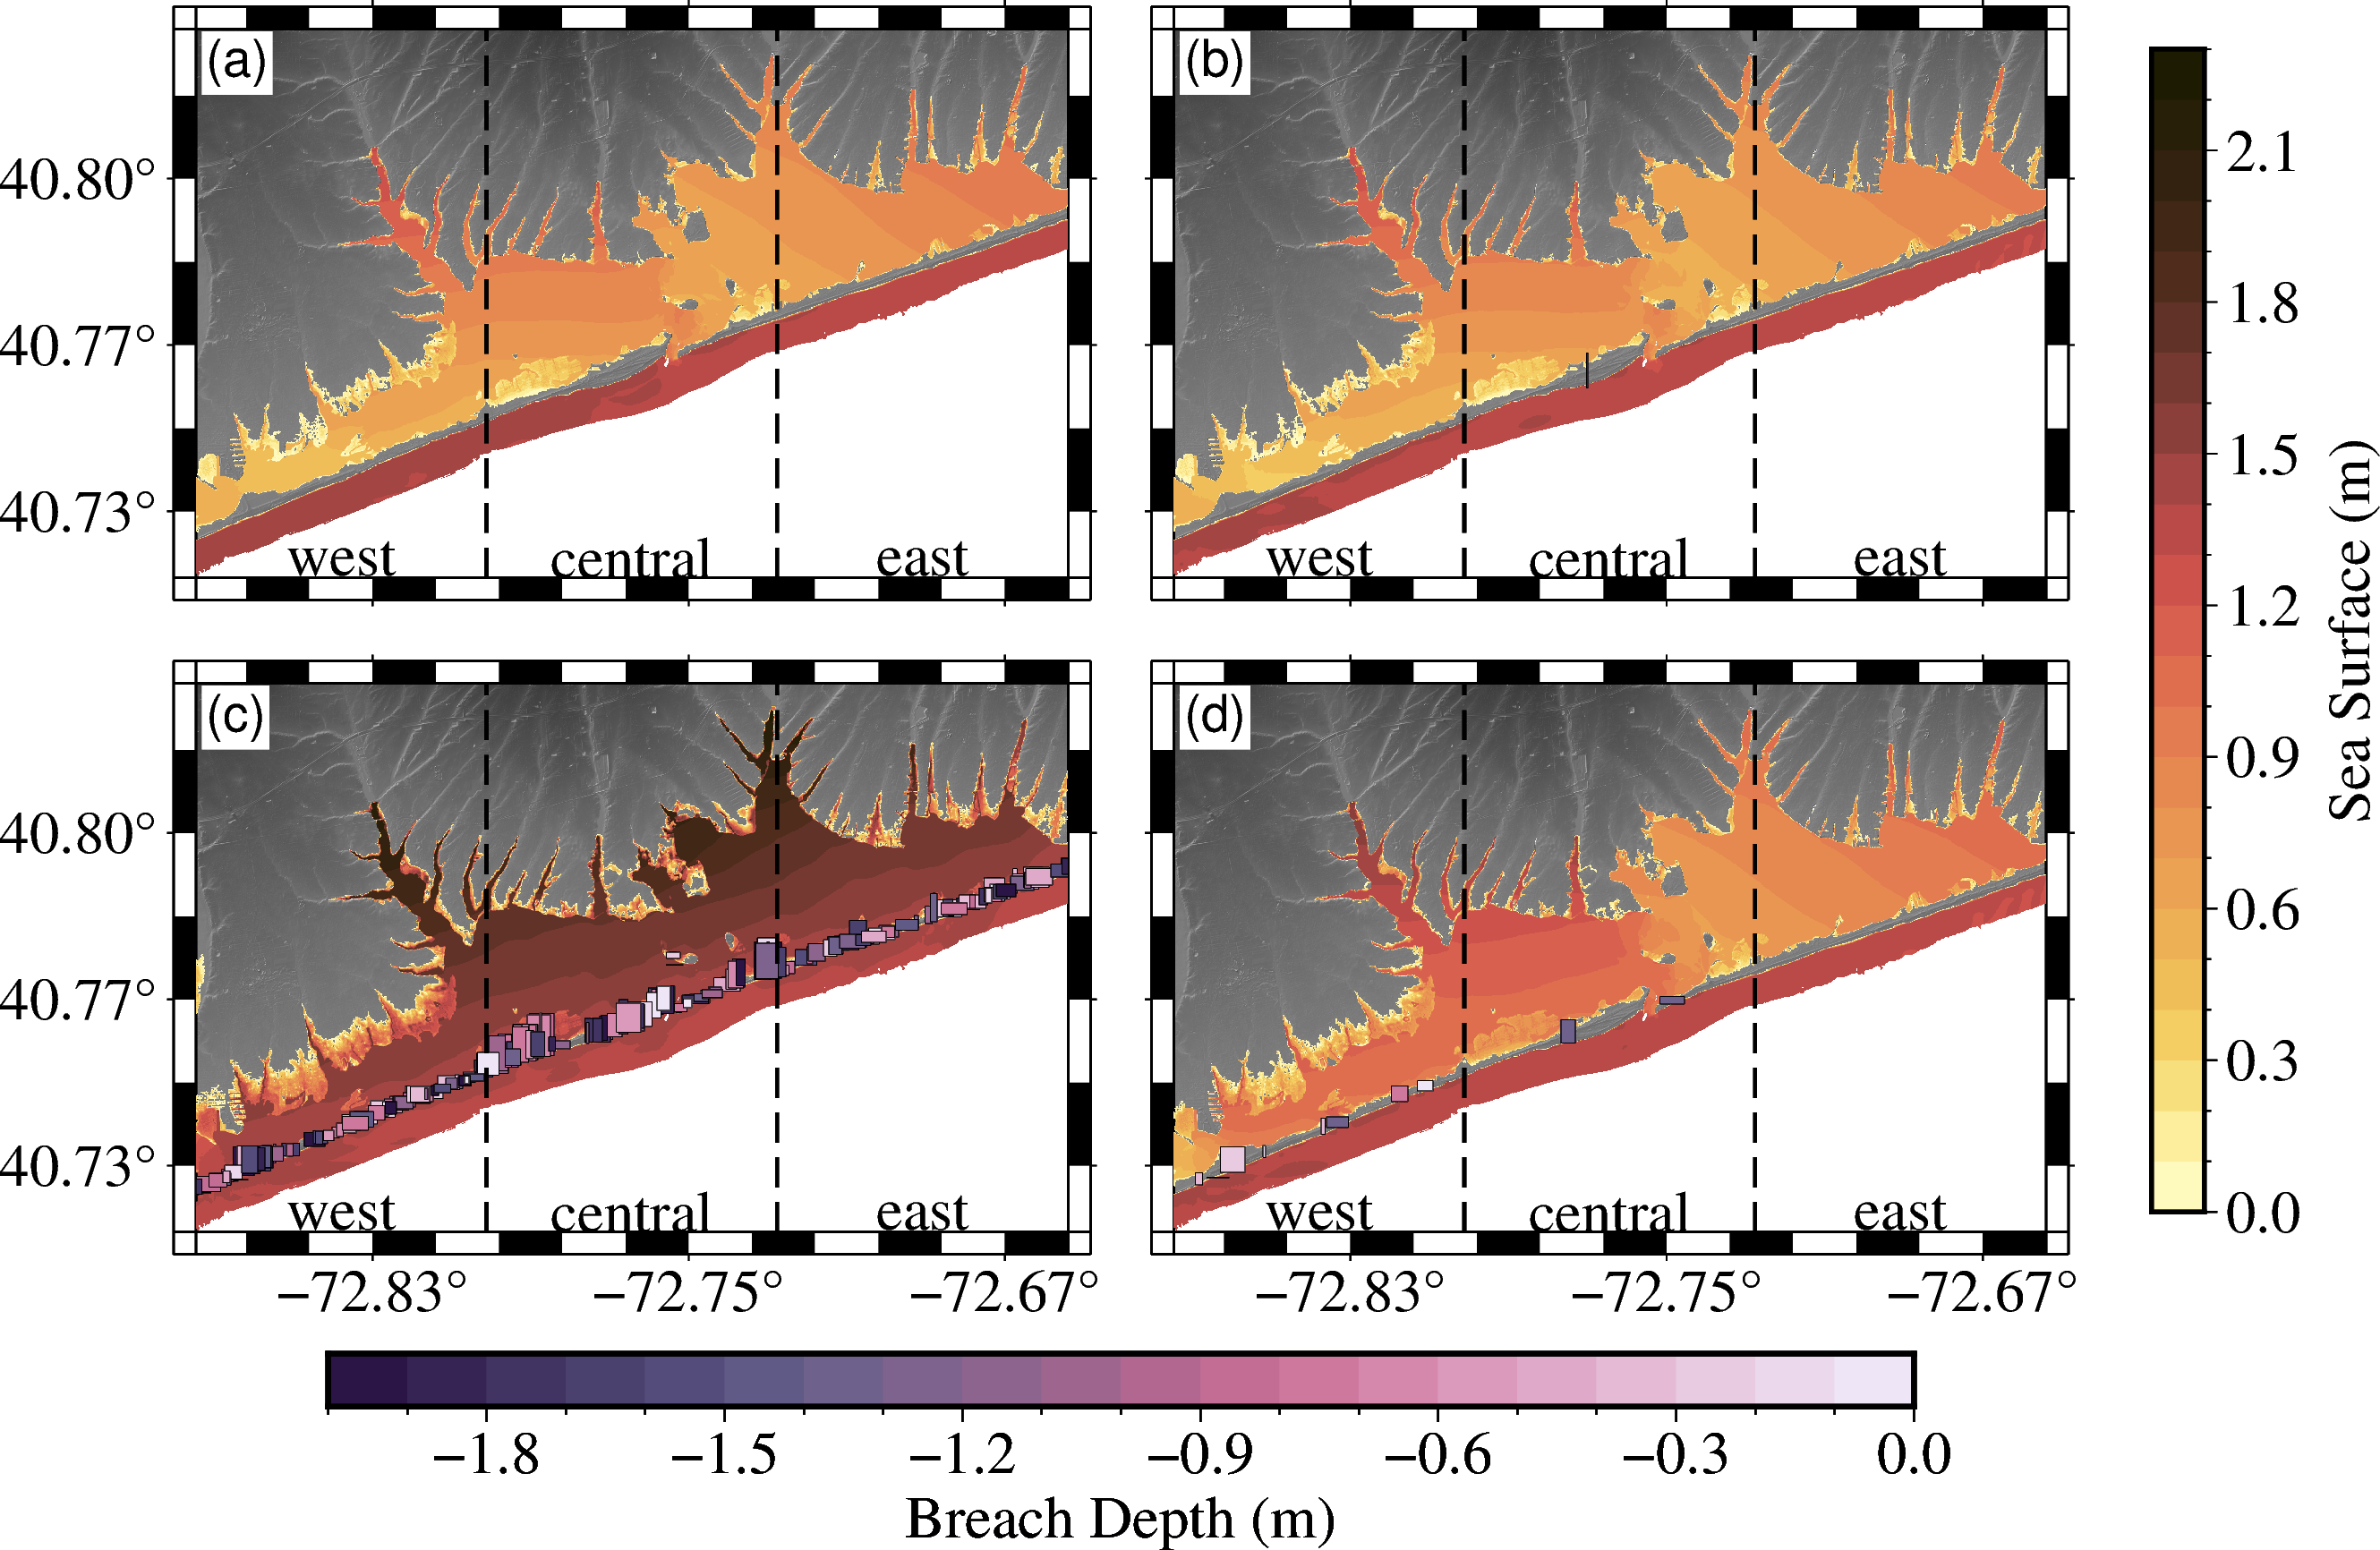

psconvert [INFORMATION]: Processing /home/catherinej/.gmt/sessions/gmt_session.1355970/gmt_2.ps-...
psconvert [INFORMATION]: Find HiResBoundingBox ...
psconvert [INFORMATION]: Figure dimensions: Width: 642.096 points [22.6517 cm]  Height: 239.292 points [8.44169 cm]
psconvert [INFORMATION]: [2827.49 2795.51 3469.59 3034.8]...
psconvert [INFORMATION]: An unknown psconvert setting was found but since image coordinates seem to be geographical, a linear transformation will be used.
psconvert [INFORMATION]: Convert to PNG...


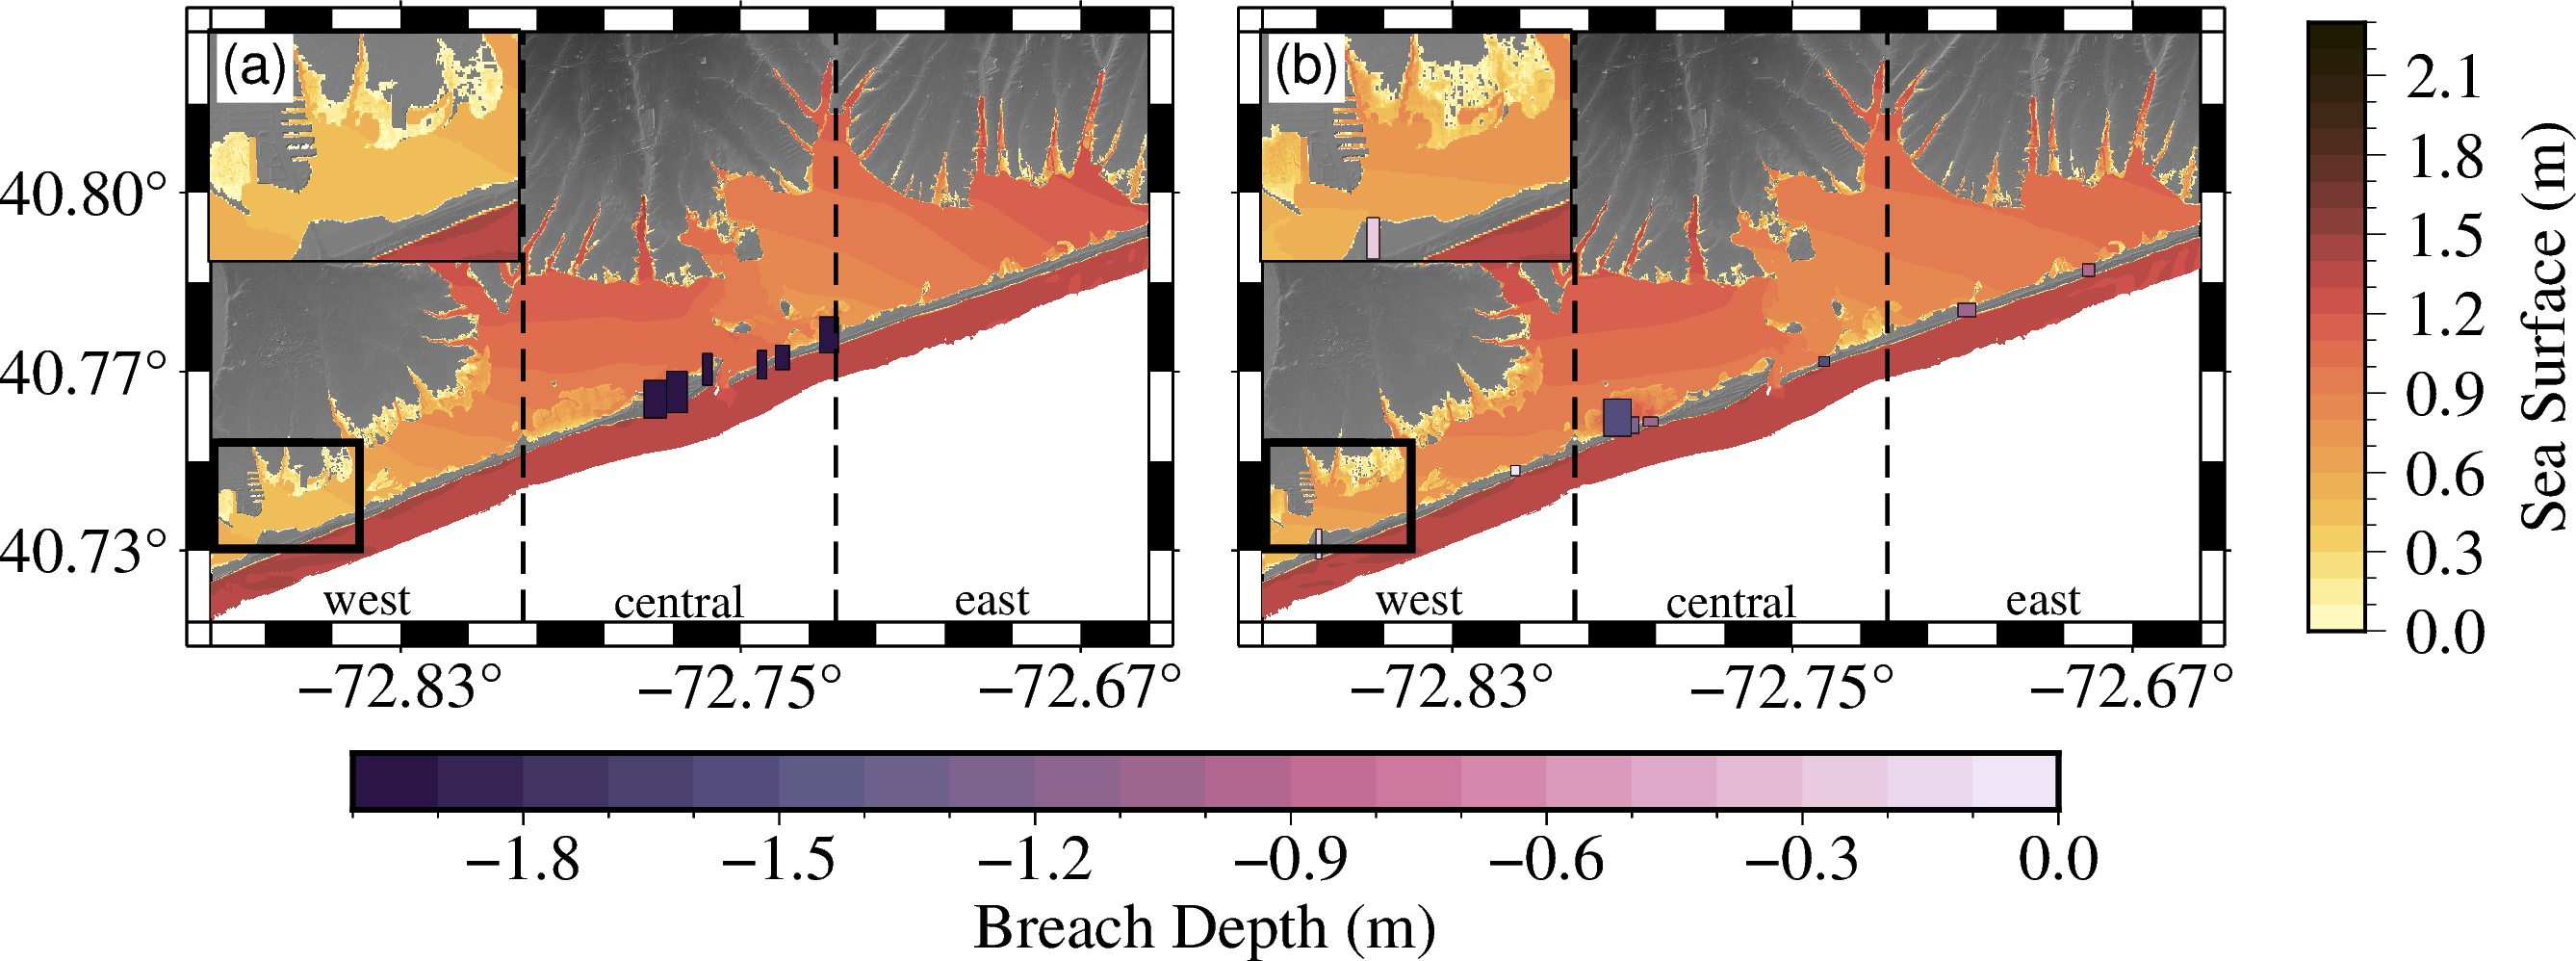

psconvert [INFORMATION]: Processing /home/catherinej/.gmt/sessions/gmt_session.1355970/gmt_3.ps-...
psconvert [INFORMATION]: Find HiResBoundingBox ...
psconvert [INFORMATION]: Figure dimensions: Width: 642.096 points [22.6517 cm]  Height: 239.292 points [8.44169 cm]
psconvert [INFORMATION]: [2827.49 2795.51 3469.59 3034.8]...
psconvert [INFORMATION]: An unknown psconvert setting was found but since image coordinates seem to be geographical, a linear transformation will be used.
psconvert [INFORMATION]: Convert to PNG...


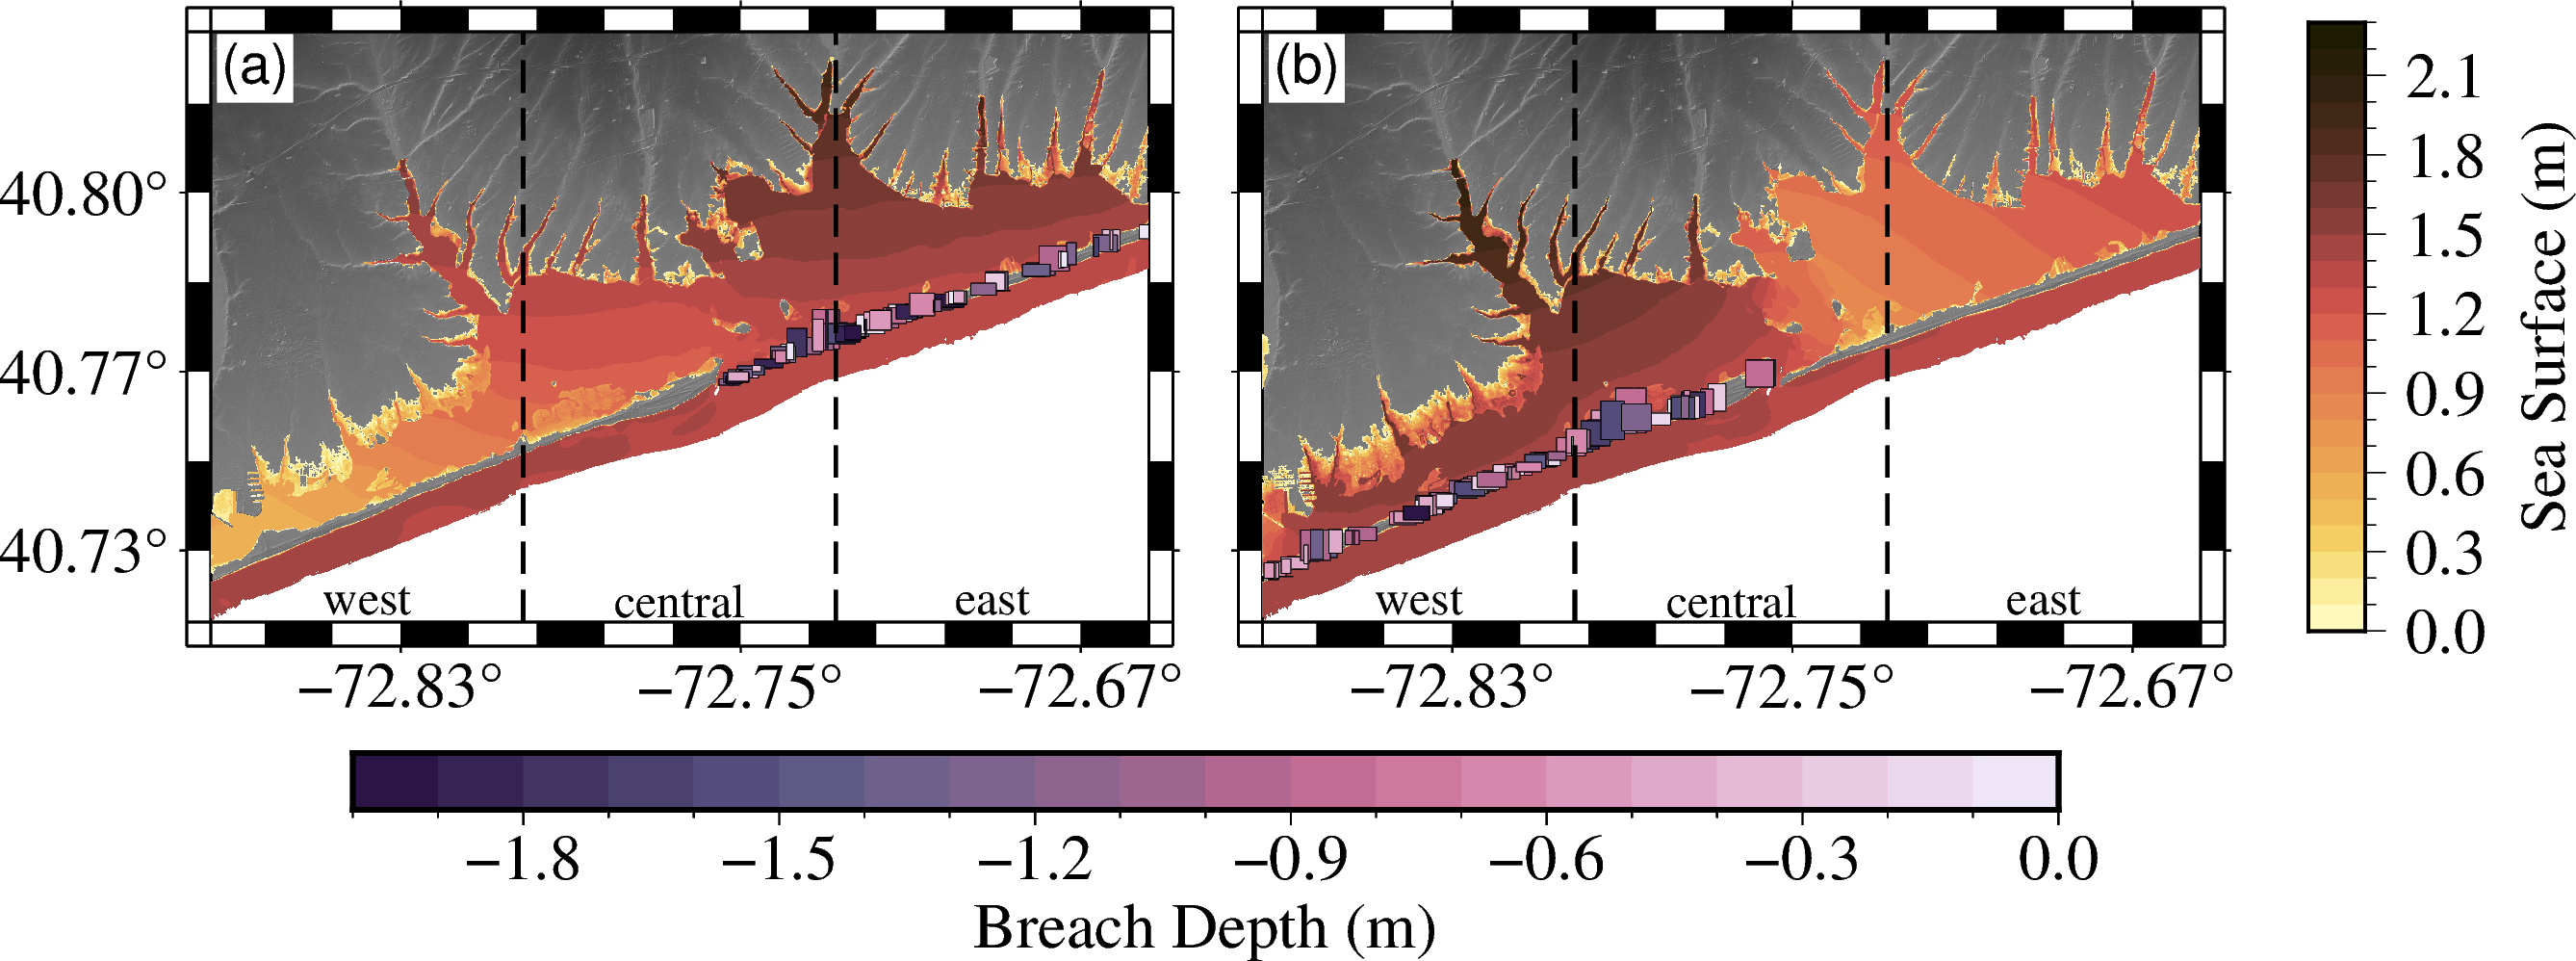

In [8]:
datadir = '/home/catherinej/BarrierIslandBreachProject/data/raw/fg_nc/'
file_names = {'min_fg': 'dw_0283_1_fgmax.nc',
              'max_fg': 'loc_0247_259_fgmax.nc',
              'mean_fg' : 'loc_0066_0011_fgmax.nc',
              'no_breach': 'no_breach_no_calc_radii_fgmax.nc'}
# file_names = {'east1': 'east_0152_91_fgmax.nc',
#               'east2': 'east_0070_52_fgmax.nc',
#               'west1': 'west_0187_52_fgmax.nc',
#               'west2': 'west_0065_98_fgmax.nc'}

fg = fgdata_organization(datadir, file_names)
# Define the order in which you want to access the items
order = ['no_breach', 'min_fg', 'max_fg', 'mean_fg']

# Create an empty OrderedDict
ordered_fgdata = OrderedDict()

# Add items to the OrderedDict in the specified order
for key in order:
    if key in fg:
        ordered_fgdata[key] = fg[key]
# print(fg['max_fg'])
test_fg_subplots(ordered_fgdata, 'fig8.pdf')



file_names = {'w_0019_6': 'w_0019_6_fgmax.nc',
              'loc_0213_11': 'loc_0213_11_fgmax.nc'}
fg = fgdata_organization(datadir, file_names)
plot_inset_subplots(fg, 'fig9.pdf')

loc_0026_0011 = xr.open_dataset(os.path.join(datadir,  'loc_0026_0011_fgmax.nc'))
d_0284_6 = xr.open_dataset(os.path.join(datadir,  'd_0284_6_fgmax.nc'))
files = {
'east_max' :'east_0152_91_fgmax.nc',
'west_max' : 'west_0065_98_fgmax.nc'
}
fg = fgdata_organization(datadir, files)
plot_fg_subplots(fg, 'fig10.pdf')

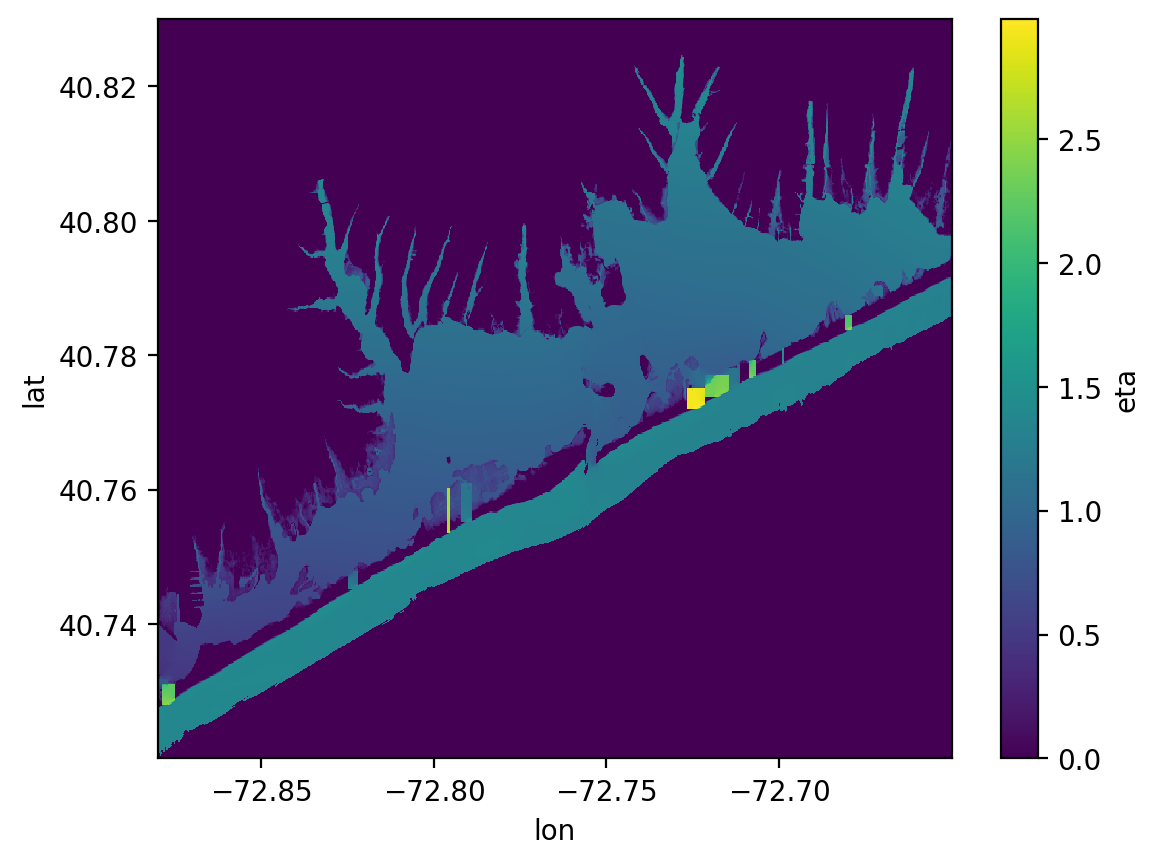

In [10]:
loc_0026_0011.eta.plot()